In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve, train_test_split

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df_attributes = pd.read_csv("/kaggle/input/scotium/scoutium_attributes.csv")

In [4]:
df_labels = pd.read_csv("/kaggle/input/scotium/scoutium_potential_labels.csv")

In [5]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [6]:
def general_info (dataframe):
    print('\033[1m' +f'{get_df_name(dataframe).upper()}'+'\033[0m')
    print("\n")
    print('\033[1m' +f" SHAPE ".center(30, '-')+'\033[0m')
    print(dataframe.shape,"\n")
    print('\033[1m' +f" VARIABLE TYPES ".center(30, '-')+'\033[0m')
    print(dataframe.info(),"\n")
    print('\033[1m' +f" NULL VALUE ".center(30, '-')+'\033[0m')
    print(dataframe.isnull().sum(),"\n")

In [7]:
general_info(df_attributes)

DF_ATTRIBUTES


----------- SHAPE ------------
(10730, 8) 

------- VARIABLE TYPES -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 670.8 KB
None 

--------- NULL VALUE ---------
task_response_id    0
match_id            0
evaluator_id        0
player_id           0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
dtype: int64 



In [8]:
df_attributes.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [9]:
general_info(df_labels)

DF_LABELS


----------- SHAPE ------------
(322, 5) 

------- VARIABLE TYPES -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   task_response_id  322 non-null    int64 
 1   match_id          322 non-null    int64 
 2   evaluator_id      322 non-null    int64 
 3   player_id         322 non-null    int64 
 4   potential_label   322 non-null    object
dtypes: int64(4), object(1)
memory usage: 12.7+ KB
None 

--------- NULL VALUE ---------
task_response_id    0
match_id            0
evaluator_id        0
player_id           0
potential_label     0
dtype: int64 



In [10]:
df_labels.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [11]:
df = df_attributes.merge(df_labels, on=["task_response_id", "match_id", "evaluator_id", "player_id"])

In [12]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [13]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print('\033[1m'f"{get_df_name(dataframe).upper()}",'\033[0m' "\n")
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [14]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"\nNumerical Columns:{num_cols}\nCategorical Columns:{cat_cols}\nCardinal Columns:{cat_but_car}")

DF 

Observations: 10730
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 0

Numerical Columns:['task_response_id', 'match_id', 'evaluator_id', 'player_id', 'position_id', 'analysis_id', 'attribute_id', 'attribute_value']
Categorical Columns:['potential_label']
Cardinal Columns:[]


In [15]:
def cat_summary(dataframe, col_name, plot=False):
  print('\033[1m' +f'{col_name.upper()}'.center(30, '-')+'\033[0m')
  print(pd.DataFrame({"Count": dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("\n")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show()
    #print("\n")

-------POTENTIAL_LABEL--------
               Count  Ratio
average         8497 79.189
highlighted     2097 19.543
below_average    136  1.267




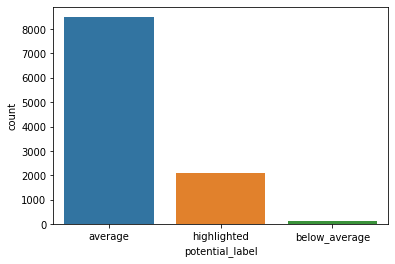

In [16]:
for col in cat_cols:
    cat_summary(df, col,plot=True)

In [17]:
def num_summary(dataframe, numerical_col, plot=False):
  print('\033[1m' +f'{numerical_col.upper()}'.center(30, '-')+'\033[0m')
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  print("\n")

  if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        print("\n")

In [18]:
num_summary(df, "attribute_value")

-------ATTRIBUTE_VALUE--------
count   10730.000
mean       55.271
std        16.048
min         1.000
5%         23.000
10%        34.000
20%        45.000
30%        45.000
40%        56.000
50%        56.000
60%        67.000
70%        67.000
80%        67.000
90%        78.000
95%        78.000
99%        78.000
max       100.000
Name: attribute_value, dtype: float64




In [19]:
df[(df["position_id"] == 1)].shape

(700, 9)

In [20]:
df = df[~(df["position_id"] == 1)]

In [21]:
df[(df["potential_label"] == "below_average")].shape

(136, 9)

In [22]:
df = df[~(df["potential_label"] == "below_average")]

In [23]:
df_player = pd.pivot_table(data=df, values="attribute_value", columns="attribute_id", index = ["player_id","position_id","potential_label"]).reset_index()

In [24]:
df_player.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [25]:
df_player.columns = df_player.columns.astype(str)

In [26]:
def label_encoder(dataframe, col):
    labelencoder = LabelEncoder()
    dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe

In [27]:
df_player = label_encoder(df_player,"potential_label")

In [28]:
df_player.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [29]:
num_cols = df_player.columns.to_list()
for i in range(3):
    num_cols.pop(0)

In [30]:
num_cols

['4322',
 '4323',
 '4324',
 '4325',
 '4326',
 '4327',
 '4328',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4352',
 '4353',
 '4354',
 '4355',
 '4356',
 '4357',
 '4407',
 '4408',
 '4423',
 '4426']

In [31]:
df_player[num_cols] = StandardScaler().fit_transform(df_player[num_cols])

In [32]:
df_player.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,-1.405,-0.438,-0.767,-0.795,-0.907,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,0.013,-1.282,-1.132,-0.495,-1.235,-1.520,-0.143,-1.487,-0.955,-0.253
1,1356362,9,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
2,1356375,3,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
3,1356375,4,0,0.595,1.308,0.679,0.683,0.723,1.482,1.355,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,1.560,0.814,0.428,0.632,0.198,0.768,-0.143,0.669,-0.276,-0.253
4,1356411,9,0,0.595,0.561,1.373,1.430,0.723,0.723,0.601,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,0.787,0.115,0.428,0.632,0.198,0.768,1.874,-0.050,1.083,1.042


In [33]:
X = df_player.drop(["player_id", "position_id", "potential_label"], axis=1)
y = df_player["potential_label"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [35]:
models = [('KNN', KNeighborsClassifier()),
          ('CART',DecisionTreeClassifier()),
          ('RF',RandomForestClassifier()),
          ('GBM',GradientBoostingClassifier()),
          ('XGBoost',XGBClassifier()),
          ('CatBoost',CatBoostClassifier(verbose=False)),
          ("LightGBM", LGBMClassifier())]

In [36]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy','f1','roc_auc'])
    print('\033[1m' +f" {name} ".center(30, '-')+'\033[0m')
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1 Score: {cv_results['test_f1'].mean()}")
    print(f"ROC AUC Score: {cv_results['test_roc_auc'].mean()}")
    print("\n")

------------ KNN -------------
Accuracy: 0.8523232323232325
F1 Score: 0.4656841198017669
ROC AUC Score: 0.8051268498942917


------------ CART ------------
Accuracy: 0.8157575757575757
F1 Score: 0.5986335403726708
ROC AUC Score: 0.751444679351656


------------- RF -------------
Accuracy: 0.8597979797979798
F1 Score: 0.5606994312876666
ROC AUC Score: 0.8982205778717407


------------ GBM -------------
Accuracy: 0.8523905723905724
F1 Score: 0.5917948717948718
ROC AUC Score: 0.8732910500352361


---------- XGBoost -----------
Accuracy: 0.8561616161616161
F1 Score: 0.6258721670486376
ROC AUC Score: 0.8713530655391122


---------- CatBoost ----------
Accuracy: 0.8783164983164984
F1 Score: 0.6245098039215686
ROC AUC Score: 0.8893587033121918


---------- LightGBM ----------
Accuracy: 0.8746127946127945
F1 Score: 0.6479059829059829
ROC AUC Score: 0.8867512332628611




In [37]:
import optuna

In [38]:
def objective(trial):
    param = {
      'iterations': trial.suggest_int("iterations", 100, 1000),
      'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
      'depth': trial.suggest_int("depth", 4, 10),
      'random_state': 42,
      'verbose': False,
      }

    model = CatBoostClassifier(**param)  
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return accuracy_score(y_test, y_pred)

In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-20 20:14:46,086] A new study created in memory with name: no-name-061764ed-eacb-4b02-9d4f-df9737dd7d11
[I 2023-04-20 20:14:47,300] Trial 2 finished with value: 0.8727272727272727 and parameters: {'iterations': 789, 'learning_rate': 0.08994997888915496, 'depth': 4}. Best is trial 2 with value: 0.8727272727272727.
[I 2023-04-20 20:14:48,891] Trial 0 finished with value: 0.8727272727272727 and parameters: {'iterations': 546, 'learning_rate': 0.0077049747540318715, 'depth': 8}. Best is trial 2 with value: 0.8727272727272727.
[I 2023-04-20 20:14:49,676] Trial 3 finished with value: 0.8727272727272727 and parameters: {'iterations': 884, 'learning_rate': 0.012009428275478306, 'depth': 8}. Best is trial 2 with value: 0.8727272727272727.
[I 2023-04-20 20:14:49,965] Trial 5 finished with value: 0.8545454545454545 and parameters: {'iterations': 635, 'learning_rate': 0.027457868658234685, 'depth': 4}. Best is trial 2 with value: 0.8727272727272727.
[I 2023-04-20 20:14:50,627] Trial 7 fi

Number of finished trials: 50
Best trial: {'iterations': 789, 'learning_rate': 0.08994997888915496, 'depth': 4}


In [40]:
cat_model = CatBoostClassifier(**study.best_trial.params,verbose=False).fit(X_train, y_train)

In [41]:
y_pred = cat_model.predict(X_test)

In [42]:
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"ROC = {roc_auc_score(y_test, y_pred)}")
print(f"F1 = {f1_score(y_test, y_pred)}")

Accuracy = 0.8545454545454545
ROC = 0.6363636363636364
F1 = 0.42857142857142855


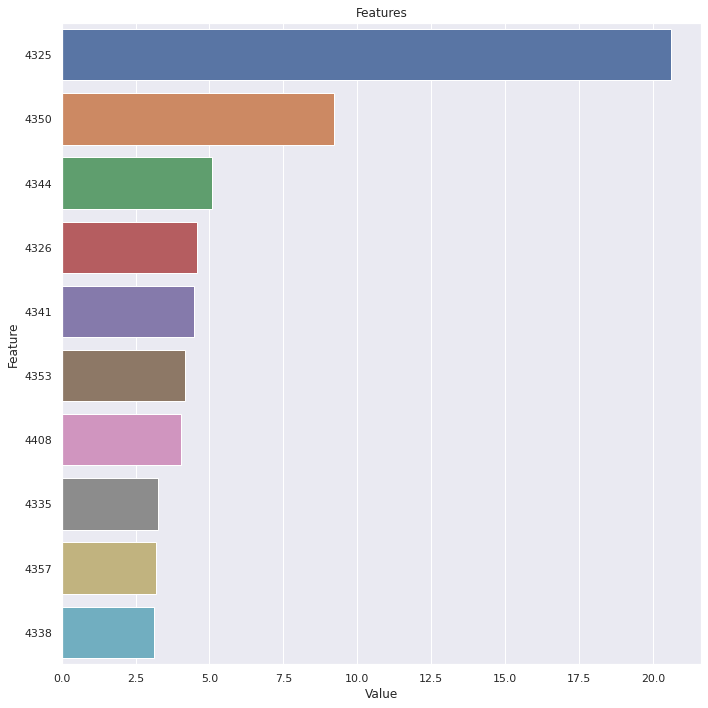

In [43]:
def plot_importance(model, features, num=30, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(cat_model, X_train, 10)